# Proyecto Final: *MiBici*

**Nombre:** Sofia Daniela Rodriguez Saenz

**e-mail:** sofia.rodriguez5540@alumnos.udg.mx

**Nombre:** Alejandra Elizabeth Trujillo Navarro

**e-mail:** alejandra.trujillo2826@alumnos.udg.mx


# Descripción del proyecto
En este proyecto nos centraremos en el análisis y la visualización de datos
provenientes del sistema de bicicletas compartidas, el cual es una programa
ecológica y sostenible. A través de la recolección y el estudio de datos detallados sobre el uso de las bicicletas, estaciones, y otros factores relevantes como edad y género, este proyecto busca ofrecer detalles relevantes para mejorar el servicio de MiBici.
Al analizar cómo, cuándo y dónde se utilizan las bicicletas compartidas, podemos obtener detalles sobre las necesidades y preferencias de los usuarios, lo que a su vez puede guiar mejoras en la infraestructura, la distribución de las estaciones y la promoción de hábitos de transporte más sostenibles.
## Capa 1: Panel de control para generación del dataset
El propósito de esta capa es permitir al usuario generar o filtrar el conjunto de datos que será analizado. Se utilizarán los datos abiertos de MiBici, disponibles en la siguiente liga: https://www.mibici.net/es/datos-abiertos/. Será posible seleccionar rangos de fechas, estaciones específicas de bicicletas tanto de retiro como de
arribo, y segmentar los datos por género y edad de los usuarios.
## Capa 2: Representación gráfica del dataset
En esta capa, se presentará una representación gráfica del conjunto de datos
filtrado o generado en la Capa 1. Exhibiremos un mapa detallado de la ciudad,
señalando la ubicación de las estaciones y su respectivo número identificativo.
Además, incorporaremos una codificación por colores para destacar las estaciones de mayor uso.
## Capa 3: Panel de Control para Selección de Métricas y
Visualización de Resultados
Esta capa permitiría al usuario seleccionar diferentes métricas para analizar el dataset y visualizar los resultados de manera gráfica.
* Distancia total recorrida: Un histograma o gráfico de líneas mostrando la
distancia total recorrida por mes.
* Duración promedio de los viajes: Gráficos de barras que muestren la duración promedio de los viajes por estación.
* Densidad de uso por hora del día: Gráficos de líneas que muestren cómo
varía el uso de las bicicletas a lo largo del día, identificando las horas pico.

# MODULES

In [1]:
!pip install folium

In [87]:
import errno
import requests
import os
import pandas as pd
import panel as pn
import panel.widgets as pnw
from datetime import datetime
import folium
import branca.colormap as cm
import plotly.graph_objects as go

pn.extension('plotly')

# CLASSES

# FUNCTIONS

In [3]:
def saveUrlData(url, path, filename):
  response = requests.get(url, headers=headers)
  if response.status_code == 200:
      # Abrir el archivo en modo binario y escribir los datos descargados
      ruta = path+filename+'.csv'
      with open(ruta, "wb") as archivo:
          archivo.write(response.content)
      print(f"Archivo guardado como {filename}.csv")
  else:
      print(f"Error al descargar el archivo. Código de respuesta: {response.status_code}")


In [4]:
def folderCreate(path):
  try:
    os.mkdir(path)
  except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [5]:
def getDF(path):
  df = pd.DataFrame()
  #Iterar sobre los archivos contenidos en el folder
  for archivo in os.listdir(path):
    print("Aniadiendo archivo "+archivo)
    if archivo.endswith("csv"):
      #Extraemos el nombre del mes
      mes = archivo.split('.')[0]

      #Guardamos datos del archivo en un df temporal
      temp_df = pd.read_csv(os.path.join(path, archivo), encoding='iso-8859-1')
      temp_df['Mes'] = mes
      #combinamos los dataframes
      df = pd.concat([df, temp_df], ignore_index=True)
  return df



In [45]:
def filterDF(datos, origen_id, destino_id, genero, edad, fecha_retiro, fecha_arribo):
    anio_actual = datetime.now().year
    filteredDf = datos
    if origen_id != 'Todo':
        filteredDf = filteredDf[(filteredDf['Origen_Id'] == origen_id)]
    if destino_id != 'Todo':
        filteredDf = filteredDf[filteredDf['Destino_Id'] == destino_id]
    if genero != 'Todo':
        filteredDf = filteredDf[filteredDf['Genero'] == genero]
    if fecha_retiro != None:
        filteredDf = filteredDf[filteredDf['Inicio_del_viaje'] >= pd.to_datetime(fecha_retiro)]
    if fecha_arribo != None:
        filteredDf = filteredDf[filteredDf['Fin_del_viaje'] >= pd.to_datetime(fecha_retiro)]
    filteredDf = filteredDf[filteredDf['Año_de_nacimiento'] >= anio_actual - edad]
    return filteredDf

In [33]:
def plotStations(estacionesDf, dataDf):
    # Definir coordenadas de  Guadalajara, Mexico
    guadalajara_coordinates = [20.6597, -103.3496]
    # Crear mapa centrado en Guadalajara
    aux = dataDf
    aux['Num_viajes'] = 1
    
    aux = aux.groupby(['Origen_Id']).agg({'Num_viajes': 'count'}).reset_index()
    guadalajara_map = folium.Map(location=guadalajara_coordinates, zoom_start=12)
    df = pd.merge(left=aux, right=estacionesDf, left_on='Origen_Id', right_on='id')
    
    # Definir colormap
    df.sort_values(by='Num_viajes', ascending=True)
    max_cantidad = df['Num_viajes'].max()
    min_cantidad = df['Num_viajes'].min()
    colormap = cm.linear.YlGn_07.scale(min_cantidad, max_cantidad)

    for index, row in df.iterrows():
        lat = row["latitude"]
        lon = row["longitude"]
        color = colormap(row['Num_viajes'])
        folium.Circle(
            location=[lat, lon],
            radius=50,  # Radio fijo para todos los círculos
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            popup=f'Valor: {row["Num_viajes"]}'
        ).add_to(guadalajara_map)
    colormap.caption = 'Número de viajes'
    guadalajara_map.add_child(colormap)
    return guadalajara_map


# Obtener datos de MiBici

In [8]:
# Creamos una carpeta para guardar los archivos
folderCreate('MiBici')
# URL donde se encuentran guardados los archivos de Ecobici
urls = {'Enero':r'https://www.mibici.net/site/assets/files/43035/datos_abiertos_2023_03.csv',
        'Febrero': r'https://www.mibici.net/site/assets/files/40197/datos_abiertos_2023_02.csv',
        'Marzo': r'https://www.mibici.net/site/assets/files/43035/datos_abiertos_2023_03.csv',
        'Abril': r'https://www.mibici.net/site/assets/files/46758/datos_abiertos_2023_04.csv',
        'Mayo': r'https://www.mibici.net/site/assets/files/46759/datos_abiertos_2023_05.csv',
        'Junio': r'https://www.mibici.net/site/assets/files/48116/datos_abiertos_2023_06.csv',
        'Julio': r'https://www.mibici.net/site/assets/files/49448/datos_abiertos_2023_07.csv',
        'Agosto': r'https://www.mibici.net/site/assets/files/51295/datos_abiertos_2023_08.csv',
        'Septiembre': r'https://www.mibici.net/site/assets/files/53344/datos_abiertos_2023_09.csv',
        'Octubre': r'https://www.mibici.net/site/assets/files/54935/datos_abiertos_2023_10.csv',
        'Noviembre': r'https://www.mibici.net/site/assets/files/57344/datos_abiertos_2023_11.csv',
        'Diciembre': r'https://www.mibici.net/site/assets/files/58715/datos_abiertos_2023_12.csv'
        }

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

# Realizar la solicitud GET para obtener archivo
#Descargaremos cada uno de los archivos de 2023 ya que 2024 no esta completo aun
for mes, url in urls.items():
    url_tmp = url
    print("Descargando datos: ", url, " ....")
    saveUrlData(url,r'MiBici/',mes)

Descargando datos:  https://www.mibici.net/site/assets/files/43035/datos_abiertos_2023_03.csv  ....
Archivo guardado como Enero.csv
Descargando datos:  https://www.mibici.net/site/assets/files/40197/datos_abiertos_2023_02.csv  ....
Archivo guardado como Febrero.csv
Descargando datos:  https://www.mibici.net/site/assets/files/43035/datos_abiertos_2023_03.csv  ....
Archivo guardado como Marzo.csv
Descargando datos:  https://www.mibici.net/site/assets/files/46758/datos_abiertos_2023_04.csv  ....
Archivo guardado como Abril.csv
Descargando datos:  https://www.mibici.net/site/assets/files/46759/datos_abiertos_2023_05.csv  ....
Archivo guardado como Mayo.csv
Descargando datos:  https://www.mibici.net/site/assets/files/48116/datos_abiertos_2023_06.csv  ....
Archivo guardado como Junio.csv
Descargando datos:  https://www.mibici.net/site/assets/files/49448/datos_abiertos_2023_07.csv  ....
Archivo guardado como Julio.csv
Descargando datos:  https://www.mibici.net/site/assets/files/51295/datos_ab

In [22]:
#Procederemos a guardar en 1 Dataframe y conmbinarlos en 1 solo archivo
global data
data = getDF(r'MiBici/')
data['Inicio_del_viaje'] = pd.to_datetime(data['Inicio_del_viaje'], infer_datetime_format=True, errors='coerce')
data['Fin_del_viaje'] = pd.to_datetime(data['Fin_del_viaje'], infer_datetime_format=True, errors='coerce')

Aniadiendo archivo Agosto.csv
Aniadiendo archivo Septiembre.csv
Aniadiendo archivo Mayo.csv
Aniadiendo archivo Octubre.csv
Aniadiendo archivo Noviembre.csv
Aniadiendo archivo Marzo.csv
Aniadiendo archivo Abril.csv
Aniadiendo archivo Enero.csv
Aniadiendo archivo Febrero.csv
Aniadiendo archivo Junio.csv
Aniadiendo archivo Julio.csv
Aniadiendo archivo Estaciones
Aniadiendo archivo Diciembre.csv


/var/folders/0b/6tfp3yw96pz6qkldgvm65_180000gn/T/ipykernel_15008/65778291.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['Inicio_del_viaje'] = pd.to_datetime(data['Inicio_del_viaje'], infer_datetime_format=True, errors='coerce')
/var/folders/0b/6tfp3yw96pz6qkldgvm65_180000gn/T/ipykernel_15008/65778291.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['Fin_del_viaje'] = pd.to_datetime(data['Fin_del_viaje'], infer_datetime_format=True, errors='coerce')


In [23]:
data[data['Mes']=='Enero']['Viaje_Id'].min()

27598660

In [24]:
data['Origen_Id'].unique()

array([ 48,  27,  41, 199, 135, 191,  60, 128, 265,  79, 312, 200, 253,
        50,  65, 236, 235,  52,  64, 254,  24, 163, 229, 172, 207, 218,
       157, 260, 234, 323, 321,   4,  14, 216, 155, 175, 238,  17,  78,
        73, 171,  75, 228, 154,  77, 170,  28,  33, 112,  51, 173, 118,
       194, 184, 150, 131, 317,  11, 226,   8, 256,  13, 152, 271,   5,
        92, 230, 231, 215, 249, 193,  49,  44,  12,  30, 164, 255, 316,
       156, 276, 162, 105, 320, 284, 259,  76, 210,  58, 326,  62,  81,
       258, 311, 125, 130,  54, 281, 180,  16, 176,  95, 169,   2,  69,
       304, 269, 179, 198,  72,  57,  32,  23, 286,  82, 322, 166, 104,
       165, 158,  55, 283, 257,  56, 232,  38, 142,  63, 251,  35,  19,
       264,  91,  26, 295, 327, 182, 270,  80, 268,  85, 307,  10, 137,
       263,  61, 126,  94, 227,   9, 247,  70, 266, 324, 177, 274, 272,
       225, 185, 315, 280, 303,  45,  87, 319, 178, 262, 285, 277, 241,
       296, 115, 206, 211,  74, 167, 242,  29,  43,  93, 293, 24

In [25]:
#Obtenemos los datos de las estaciones
global estaciones
url = r'https://www.mibici.net/site/assets/files/1118/nomenclatura_2024_01.csv'
folderCreate('MiBici/Estaciones')
saveUrlData(url,r'MiBici/Estaciones/','Estaciones')
estaciones=getDF(r'MiBici/Estaciones/')

Archivo guardado como Estaciones.csv
Aniadiendo archivo Estaciones.csv


# Mapa de guadalajara

Para la visualización física de las estaciones y su representación gráfica según su uso, utilizaremos un mapa de Guadalajara. Para ello, emplearemos el módulo *folium*, que nos facilitará la realización de esta actividad.

A continuación, se muestran las coordenadas y valores correspondientes a Guadalajara:

In [26]:
# Definir coordenadas de  Guadalajara, Mexico
guadalajara_coordinates = [20.6597, -103.3496]
# Crear mapa centrado en Guadalajara
guadalajara_map = folium.Map(location=guadalajara_coordinates, zoom_start=12)
# Mostramos el mapa
guadalajara_map

# Creación del Dashboard

In [50]:
#definir funcion para quitar filtros
def clearF(event):
    origen_id.value = 'Todo'
    destino_id.value = 'Todo'
    genero.value = 'Todo'
    edad.value = 104
    fecha_retiro.value = datetime(2023, 1, 1)
    fecha_arribo.value = datetime(2023, 1, 1)

In [55]:
pn.extension()

#Definir layout de los widgets
origen_id = pn.widgets.AutocompleteInput(name='ID estación origen', options=['Todo']+list(map(str, data['Origen_Id'].unique())), width = 320, align = 'center', value='Todo')
destino_id = pn.widgets.AutocompleteInput(name='ID estación destino', options=['Todo']+list(map(str, data['Destino_Id'].unique())), width = 320, align = 'center', margin=15, value='Todo')
genero = pn.widgets.ToggleGroup(name='Género', options=['M','F', 'Todo'], behavior="radio", width = 320, align='center', value='Todo')
anio_actual = datetime.now().year
edad = pn.widgets.IntSlider(name='Edad <=', start=int(anio_actual-data['Año_de_nacimiento'].max()), end=int(anio_actual-data['Año_de_nacimiento'].min()), value=int(anio_actual-data['Año_de_nacimiento'].min()), width = 320, align = 'center')
fecha_retiro = pn.widgets.DateSlider(name='Fecha retiro desde', width = 320, align = 'center', as_datetime=True, start=datetime(2023, 1, 1), end=datetime(2023, 12, 31))
fecha_arribo = pn.widgets.DateSlider(name='Fecha arribo desde', width = 320, align = 'center', as_datetime=True, start=datetime(2023, 1, 1), end=datetime(2023, 12, 31))
clearFilter = pn.widgets.Button(name='Reset', button_type='primary', align='center')
clearFilter.on_click(clearF)

Watcher(inst=Button(align='center', button_type='primary', name='Reset'), cls=<class 'panel.widgets.button.Button'>, fn=<function clearF at 0x16b12e2a0>, mode='args', onlychanged=False, parameter_names=('clicks',), what='value', queued=False, precedence=0)

In [56]:
#Definir funcion de plotting del mapa

@pn.depends(origen_id, destino_id,genero, edad, fecha_retiro, fecha_arribo)
def plot_map(origen_id, destino_id,genero, edad, fecha_retiro, fecha_arribo):
    global estaciones, data
    filteredDf = filterDF(data, origen_id, destino_id, genero, edad, fecha_retiro, fecha_arribo)
    gdl_map = plotStations(estaciones, filteredDf)
    return gdl_map

In [67]:
#Definir funcion de plotting del histograma
@pn.depends(origen_id, destino_id,genero, edad, fecha_retiro, fecha_arribo)
def plot_barplot(origen_id, destino_id,genero, edad, fecha_retiro, fecha_arribo):
    global estaciones, data
    #Filtramos de acuerdo a los parametros del panel
    filteredDf = filterDF(data, origen_id, destino_id, genero, edad, fecha_retiro, fecha_arribo)
    
    #Obtenemos los datos de la estacion de origen junto con la cantidad de viajes
    dfMergedOrigen = pd.merge(filteredData, estaciones, left_on='Origen_Id', right_on='id')
    dfMergedOrigen['Num_viajes_origen']=1
    dfViajesEstacionOrigen = dfMergedOrigen.groupby(['obcn']).agg({'Num_viajes_origen': 'count'}).reset_index()
    dfViajesEstacionOrigen.head()
        # Ordenamos de mayor viajes a menor
    df_sorted = dfViajesEstacion.sort_values(by=['Num_viajes_origen', 'Num_viajes_destino'], ascending=False).iloc[0:19]

    # Crear figura para mostrar un grafico de barras segun la estacion
    fig = go.Figure(data=[
        go.Bar(name='Num_viajes_origen', x=df_sorted['obcn'], y=df_sorted['Num_viajes_origen'], marker_color='green'),
        go.Bar(name='Num_viajes_destino', x=df_sorted['obcn'], y=df_sorted['Num_viajes_destino'], marker_color='yellow')
    ])

    fig.update_layout(
        template='plotly_white', # This template has a white background
        plot_bgcolor='white',
        title='Número de Viajes por Estación',
        xaxis_title='Estación OBCN',
        yaxis_title='Número de Viajes',
        legend_title='Tipo de Viaje',
        xaxis={'categoryorder':'total descending'}
    )


    return fig

In [83]:
dfMergedOrigen = pd.merge(data, estaciones, left_on='Origen_Id', right_on='id')
dfMergedOrigen['Num_viajes_origen']=1
dfViajesEstacionOrigen = dfMergedOrigen.groupby(['obcn']).agg({'Num_viajes_origen': 'count'}).reset_index()
dfViajesEstacionOrigen.head()

,obcn,Num_viajes_origen
0,(GDL-235),602
1,GDL-001,24378
2,GDL-002,17886
3,GDL-003,26052
4,GDL-004,17910


In [84]:
dfMergedDestino = pd.merge(data, estaciones, left_on='Destino_Id', right_on='id')
dfMergedDestino['Num_viajes_destino']=1
dfViajesEstacionDestino = dfMergedDestino.groupby(['obcn']).agg({'Num_viajes_destino': 'count'}).reset_index()
dfViajesEstacionDestino.head()

,obcn,Num_viajes_destino
0,(GDL-235),942
1,GDL-001,26596
2,GDL-002,15470
3,GDL-003,23893
4,GDL-004,18103


In [85]:
dfViajesEstacion = pd.merge(dfViajesEstacionOrigen, dfViajesEstacionDestino, left_on='obcn', right_on='obcn')
dfViajesEstacion.head()

,obcn,Num_viajes_origen,Num_viajes_destino
0,(GDL-235),602,942
1,GDL-001,24378,26596
2,GDL-002,17886,15470
3,GDL-003,26052,23893
4,GDL-004,17910,18103


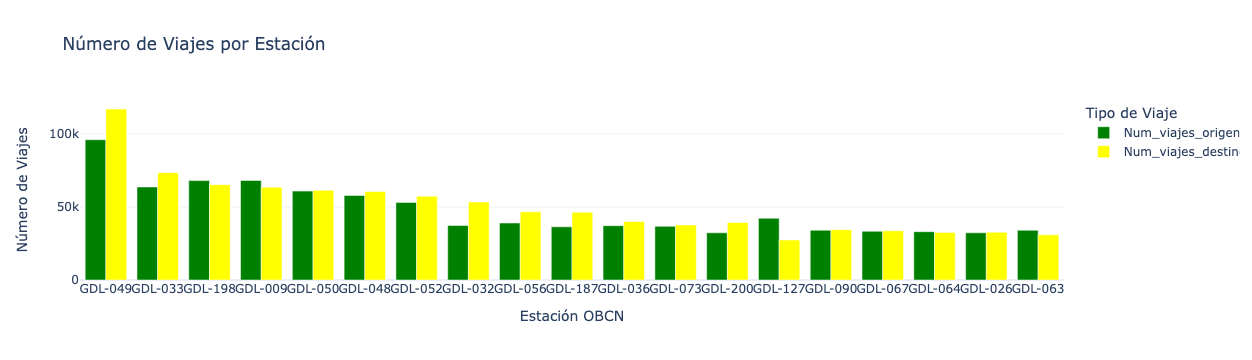

In [96]:
# Ordenamos de mayor viajes a menor
df_sorted = dfViajesEstacion.sort_values(by=['Num_viajes_origen', 'Num_viajes_destino'], ascending=False).iloc[0:19]

# Crear figura para mostrar un grafico de barras segun la estacion
fig = go.Figure(data=[
    go.Bar(name='Num_viajes_origen', x=df_sorted['obcn'], y=df_sorted['Num_viajes_origen'], marker_color='green'),
    go.Bar(name='Num_viajes_destino', x=df_sorted['obcn'], y=df_sorted['Num_viajes_destino'], marker_color='yellow')
])

fig.update_layout(
    template='plotly_white', # This template has a white background
    plot_bgcolor='white',
    title='Número de Viajes por Estación',
    xaxis_title='Estación OBCN',
    yaxis_title='Número de Viajes',
    legend_title='Tipo de Viaje',
    xaxis={'categoryorder':'total descending'}
)




In [63]:
dashboard = pn.Row(
    pn.WidgetBox(pn.pane.Markdown("# Panel options", align='center'),
                 origen_id,
                 destino_id,
                 genero,
                 edad,
                 fecha_retiro,
                 fecha_arribo,
                 clearFilter,
                 width= 380,
                 height = 450, align = 'center'),
    pn.Column(pn.pane.Markdown("### Mapa Guadalajara MiBici", align='center'),pn.pane.plot.Folium(plot_map, height=400, width=400, align='center')),
    margin=100
)
#Show dashboard embedded in colab
dashboard.servable()

Row(margin=100)
    [0] WidgetBox(align='center', height=450, sizing_mode='fixed', width=380)
        [0] Markdown(str, align='center')
        [1] AutocompleteInput(align='center', name='ID estación origen', options=['Todo', '48', ...], value='Todo', width=320)
        [2] AutocompleteInput(align='center', margin=15, name='ID estación destino', options=['Todo', '48', ...], value='Todo', width=320)
        [3] RadioButtonGroup(align='center', name='Género', options=['M', 'F', 'Todo'], value='Todo', width=320)
        [4] IntSlider(align='center', end=104, name='Edad <=', start=1, value=21, width=320)
        [5] DateSlider(align='center', as_datetime=True, end=datetime.datetime(2023, ..., name='Fecha retiro desde', start=datetime.datetime(2023, ..., value=datetime.datetime(2023, ..., width=320)
        [6] DateSlider(align='center', as_datetime=True, end=datetime.datetime(2023, ..., name='Fecha arribo desde', start=datetime.datetime(2023, ..., value=datetime.datetime(2023, ..., width=320)
        [7] Button(align='center', button_type='primary', name='Reset')
    [1] Column
        [0] Markdown(str, align='center')
        [1] Folium(Map, align='center', height=400, sizing_mode='fixed', width=400)

## Notas

Link a codigo python unicamente se encuentra aqui:
